In [73]:
import pandas as pd
import csv
import time
import numpy as np
import re
import os

import sys
sys.path.insert(0, '../')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

import collections
from collections import defaultdict

import nltk
nltk.download('stopwords')
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
stemmer = PorterStemmer()
import gensim
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import plotly
import plotly.graph_objs as go


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariabrullmartinez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### STS benchmark

In [2]:
col_names=['genre', 'file', 'year', 'feature_1','feature_2', 'sentence_1', 'sentence_2', 'feature_3','feature_4']

df_train_sts=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-train.xls', header=None, names=col_names)
df_train_sts["sent1_length"]= df_train_sts["sentence_1"].str.len()
df_train_sts["sent2_length"]= df_train_sts["sentence_2"].str.len()

df_test_sts=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-test.xls', header=None, names=col_names)
df_test_sts["sent1_length"]= df_test_sts["sentence_1"].str.len()
df_test_sts["sent2_length"]= df_test_sts["sentence_2"].str.len()

df_dev_sts=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-dev.xls', header=None, names=col_names)
df_dev_sts["sent1_length"]= df_dev_sts["sentence_1"].str.len()
df_dev_sts["sent2_length"]= df_dev_sts["sentence_2"].str.len()

df_sts=pd.concat([df_train_sts, df_test_sts, df_dev_sts])

In [3]:
print ('The lenght of the train dataset is :', df_train_sts.shape)
print ('The lenght of the test dataset is :', df_test_sts.shape)
print ('The lenght of the dev dataset is :', df_dev_sts.shape)
print ('The lenght of the total dataset is :', df_sts.shape)

The lenght of the train dataset is : (5749, 11)
The lenght of the test dataset is : (1379, 11)
The lenght of the dev dataset is : (1500, 11)
The lenght of the total dataset is : (8628, 11)


### SICK benchmark

In [4]:
df_sick = pd.read_csv("/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/SICK/SICK.txt", sep='\t')

In [5]:
df_sick=df_sick.drop('sentence_B_original', axis=1)

In [6]:
df_test_sick=df_sick.loc[df_sick['SemEval_set']=='TEST']
df_train_sick=df_sick.loc[df_sick['SemEval_set']=='TRAIN']
df_trial_sick=df_sick.loc[df_sick['SemEval_set']=='TRIAL']

In [7]:
print ('The lenght of the train dataset is :', df_train_sick.shape)
print ('The lenght of the test dataset is :', df_test_sick.shape)
print ('The lenght of the dev dataset is :', df_trial_sick.shape)
print ('The lenght of the total dataset is :', df_sick.shape)

The lenght of the train dataset is : (4439, 11)
The lenght of the test dataset is : (4906, 11)
The lenght of the dev dataset is : (495, 11)
The lenght of the total dataset is : (9840, 11)


#### Lets try to have a balance dataset for both database, therefore we will establish: 
- train: 6000 sentences
- test: 2500 sentences 
- trial: 500 sentences

In [8]:
df_test_sts=pd.concat([df_dev_sts[0:700], df_test_sts])


In [9]:
df_train_sts=pd.concat([df_dev_sts[700:1000], df_train_sts])

In [11]:
df_dev_sts=df_dev_sts[1000:]

In [12]:
print ('The lenght of the train dataset is :', df_train_sts.shape)
print ('The lenght of the test dataset is :', df_test_sts.shape)
print ('The lenght of the dev dataset is :', df_dev_sts.shape)
print ('The lenght of the total dataset is :', df_sts.shape)

The lenght of the train dataset is : (6049, 11)
The lenght of the test dataset is : (2079, 11)
The lenght of the dev dataset is : (0, 11)
The lenght of the total dataset is : (8628, 11)


In [13]:
df_train_sick=pd.concat([df_test_sick[0:1700], df_train_sick])

In [14]:
df_test_sick=df_test_sick[2000:4000]

In [15]:
print ('The lenght of the train dataset is :', df_train_sick.shape)
print ('The lenght of the test dataset is :', df_test_sick.shape)
print ('The lenght of the dev dataset is :', df_trial_sick.shape)
print ('The lenght of the total dataset is :', df_sick.shape)

The lenght of the train dataset is : (6139, 11)
The lenght of the test dataset is : (4906, 11)
The lenght of the dev dataset is : (495, 11)
The lenght of the total dataset is : (9840, 11)


### Data Preprocessing

In [16]:
STOP_WORDS = nltk.corpus.stopwords.words()
 

In [17]:
def clean_sentence(val):
    #regex = re.compile('([^\s\w]|_)+')
    sentence = val.lower()
    sentence = sentence.split(" ")
   
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word) 
            
    sentence = " ".join(sentence)
    return sentence

In [18]:
def clean_dataframe(data, colum):
    df=pd.DataFrame()

    df=pd.concat([df_train_sick['sentence_A'], df_train_sick['sentence_B']]).reset_index()
    
    df.columns=['index','sent']
    
    df = df.dropna(how="any")
   
    for col in [colum]:
        df['sentence_clean'] = df[col].apply(clean_sentence)
        df['sentence_clean'].replace(" ", "_")
   
    return df
 

In [19]:
def clean_dataframe_2(df, colum):
  
    
    df = df.dropna(how="any")
   
    for col in df['sentence_A']:
        df['sentence_clean'] = df['sentence_A'].apply(clean_sentence)
   
    return df
 

In [20]:
df = df_train_sick.dropna(how="any")
   


In [21]:
def create_data_sent(df, colum):
    
    df = df.dropna(how="any")
    
    list_sentence=[]

    #regex = re.compile('([^\s\w]|_)+')
    for val in  df[colum]:
        sentence = val.lower()
        sentence = sentence.split(" ")

        for word in list(sentence):
            if word in STOP_WORDS:
                sentence.remove(word) 

        sentence = " ".join(sentence)
        list_sentence.append(sentence)
        
    print(len(list_sentence))
    df['sentence_clean']=list_sentence
    
    return df

In [22]:
data_A= create_data_sent(df_train_sick,'sentence_A')

6139


In [23]:
data_B= create_data_sent(df_train_sick,'sentence_B')

6139


In [24]:
data=clean_dataframe(df_train_sts,'sent')

In [25]:
len(data)

12278

In [26]:
len(data['sent'].unique())

5265

In [27]:
def build_corpus(data, colum):
    corpus = []
    for col in [colum]:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
           
    return corpus

In [28]:
corpus=build_corpus(data, 'sentence_clean')

In [29]:
len(corpus)

12278

In [31]:
from gensim.models import Word2Vec

from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

In [32]:
data['list_words']=data.sentence_clean.str[0:-1].str.split(' ').tolist()

In [33]:
data

,index,sent,sentence_clean,list_words
0,5,There is no boy playing outdoors and there is ...,boy playing outdoors smiling,"[boy, playing, outdoors, smilin]"
1,6,A group of boys in a yard is playing and a man...,group boys yard playing standing background,"[group, boys, yard, playing, standing, backgroun]"
2,7,A group of children is playing in the house an...,group children playing house standing background,"[group, children, playing, house, standing, ba..."
3,9,A brown dog is attacking another animal in fro...,brown attacking another animal front tall pants,"[brown, attacking, another, animal, front, tal..."
4,10,A brown dog is attacking another animal in fro...,brown attacking another animal front pants,"[brown, attacking, another, animal, front, pant]"
...,...,...,...,...
12273,9832,A bald man in a band is playing guitar in the ...,bald band playing guitar spotlight,"[bald, band, playing, guitar, spotligh]"
12274,9836,The man is not playing the drums,playing drums,"[playing, drum]"
12275,9837,A bicyclist is holding a bike over his head in...,bicyclist holding bike head group people,"[bicyclist, holding, bike, head, group, peopl]"
12276,9838,A man is jumping rope outside,jumping rope outside,"[jumping, rope, outsid]"


In [34]:
sentence=data['list_words'].to_list()

In [36]:
len(sentence)

12278

### Apply model 

In [37]:
m = word2vec.Word2Vec(sentence, size=100, min_count=1, workers=4)

In [38]:
vocab=m.wv.vocab

In [39]:
len(vocab)

2807

### Obtain the vector per sentence

We will obtain the vector per sentence separately for data_A, and for data_B.

In [40]:
def vectorizer(sent,m):
    vec=[]
    numw=0
    
    for w in sent:
        try:
            if numw==0:
                vec=m[w]
            else: 
                vec=np.add(vec, m[w])
            numw+=1
        except:
            pass
        
    return np.asarray(vec) / numw

In [41]:
data_A['list_words_A']=data_A.sentence_clean.str[0:-1].str.split(' ').tolist()
sentence_A=data_A['list_words_A'].to_list()

In [42]:
data_B['list_words_B']=data_B.sentence_clean.str[0:-1].str.split(' ').tolist()
sentence_B=data_B['list_words_B'].to_list()

In [43]:
def obtain_sentence_vector(sentence):   
    l=[]

    for i in sentence:
        l.append(vectorizer(i,m))

    X=np.array(l)
    
    return X

In [44]:
X_A=obtain_sentence_vector(sentence_A)

<ipython-input-40-61275ca5e32f>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec=m[w]
<ipython-input-40-61275ca5e32f>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec=np.add(vec, m[w])


In [45]:
X_B=obtain_sentence_vector(sentence_B)

<ipython-input-40-61275ca5e32f>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec=m[w]
<ipython-input-40-61275ca5e32f>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec=np.add(vec, m[w])


In [46]:
len(X_B)

6139

In [47]:
df_final=data_A[['sentence_A', 'list_words_A']]

In [48]:
df_final[['sentence_B', 'list_words_B']]=data_B[['sentence_B', 'list_words_B']]

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [49]:
df_final['mean_vector_A']= list(X_A)
df_final['mean_vector_B']= list(X_B)

<ipython-input-49-a85096d7fafa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['mean_vector_A']= list(X_A)
<ipython-input-49-a85096d7fafa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['mean_vector_B']= list(X_B)


In [50]:
df_final=df_final.reset_index()

Calculate the cosine distance between the two mean vectors.

In [51]:
from scipy import spatial

In [52]:
list_cos=[]

for i in range (len(df_final)):
    res= (1 - spatial.distance.cosine(df_final['mean_vector_A'][i],df_final['mean_vector_B'][i]))
    list_cos.append(res)

In [53]:
len(list_cos)

6139

In [54]:
df_final['dist_cos']=list_cos

In [55]:
df_final

,index,sentence_A,list_words_A,sentence_B,list_words_B,mean_vector_A,mean_vector_B,dist_cos
0,5,There is no boy playing outdoors and there is ...,"[boy, playing, outdoors, smilin]",A group of kids is playing in a yard and an ol...,"[group, kids, playing, yard, old, standing, ba...","[-0.21429284, 0.09112359, 0.05202782, -0.24113...","[-0.25212032, 0.10952699, 0.064085044, -0.2887...",0.999870
1,6,A group of boys in a yard is playing and a man...,"[group, boys, yard, playing, standing, backgroun]",The young boys are playing outdoors and the ma...,"[young, boys, playing, outdoors, smiling, nearb]","[-0.27004054, 0.11861211, 0.067443065, -0.3098...","[-0.20310707, 0.09119358, 0.050980374, -0.2350...",0.999949
2,7,A group of children is playing in the house an...,"[group, children, playing, house, standing, ba...",The young boys are playing outdoors and the ma...,"[young, boys, playing, outdoors, smiling, nearb]","[-0.2622532, 0.11449351, 0.06541927, -0.299947...","[-0.20310707, 0.09119358, 0.050980374, -0.2350...",0.999938
3,9,A brown dog is attacking another animal in fro...,"[brown, attacking, another, animal, front, tal...",A brown dog is attacking another animal in fro...,"[brown, attacking, another, animal, front, pant]","[-0.21504, 0.0962875, 0.052011628, -0.24964492...","[-0.23563944, 0.10411026, 0.056666553, -0.2712...",0.999996
4,10,A brown dog is attacking another animal in fro...,"[brown, attacking, another, animal, front, pant]",A brown dog is helping another animal in front...,"[brown, helping, another, animal, front, pant]","[-0.23563944, 0.10411026, 0.056666553, -0.2712...","[-0.23893152, 0.10500013, 0.058312286, -0.2761...",0.999995
...,...,...,...,...,...,...,...,...
6134,9832,A door is being opened by a man,[opene],A bald man in a band is playing guitar in the ...,"[bald, band, playing, guitar, spotligh]","[0.0011909533, -0.00047562766, 0.002919638, -0...","[-0.12299605, 0.051961344, 0.033220924, -0.137...",-0.014555
6135,9836,Someone is boiling okra in a pot,"[someone, boiling, okr]",The man is not playing the drums,"[playing, drum]","[-0.15734847, 0.06900994, 0.04406911, -0.18544...","[-0.14375556, 0.06628352, 0.037264865, -0.1517...",0.998408
6136,9837,The man is singing heartily and playing the gu...,"[singing, heartily, playing, guita]",A bicyclist is holding a bike over his head in...,"[bicyclist, holding, bike, head, group, peopl]","[-0.15180147, 0.065046996, 0.03991281, -0.1639...","[-0.24253584, 0.10082939, 0.059706673, -0.2855...",0.999040
6137,9838,A man in blue has a yellow ball in the mitt,"[blue, yellow, bal]",A man is jumping rope outside,"[jumping, rope, outsid]","[-0.32614735, 0.14461873, 0.08157906, -0.38382...","[-0.21396096, 0.09454978, 0.05243293, -0.24362...",0.999868


In order to see how good the word2ec is, we will be clustering the vectors we have obtained for each sentence, and see if there is a correlation with a high cosine distance. The hypothesis will be that, the higher the cosine distance, the more probably it is that we find the pair of sentences in the same cluster.

### Clustering

In [56]:
def plot_elbow (mean_vector):

    wcss=[]

    for i in range(1,20):
        kmeans=KMeans(n_clusters=i, init='k-means++')
        kmeans.fit(mean_vector)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1,20), wcss)
    plt.title('Elbow method')
    plt.xlabel('Num of cluster')
    plt.ylabel('WCSS')
    plt.show()

In [101]:
def obtain_best_num_cluster(data):    
    #scaler = StandardScaler()
    #scaler.fit(data)
    #scaled_matrix = scaler.transform(data)
    
    scores = []
    n_clusters = [8,9,10,11,12,13,14,15,16,17,18]

    for n_clu in n_clusters:
        kmeans = MiniBatchKMeans(init='k-means++', n_clusters=n_clu, batch_size=10000, random_state=8)
        kmeans.fit(data)
        clusters_clients = kmeans.predict(data)
        silhouette_avg = silhouette_score(data, clusters_clients)
        print('Silhouette Score: {:<.3f}'.format(silhouette_avg))
        scores.append(silhouette_avg)
    plt.plot(n_clusters, scores)
    


Silhouette Score: 0.448
Silhouette Score: 0.435
Silhouette Score: 0.440
Silhouette Score: 0.429
Silhouette Score: 0.413
Silhouette Score: 0.405
Silhouette Score: 0.408
Silhouette Score: 0.384
Silhouette Score: 0.377
Silhouette Score: 0.367
Silhouette Score: 0.349


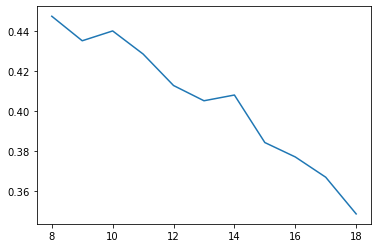

In [102]:
obtain_best_num_cluster(X_A)

Silhouette Score: 0.281
Silhouette Score: 0.252
Silhouette Score: 0.237
Silhouette Score: 0.247
Silhouette Score: 0.262
Silhouette Score: 0.225
Silhouette Score: 0.237
Silhouette Score: 0.213
Silhouette Score: 0.211
Silhouette Score: 0.207
Silhouette Score: 0.213


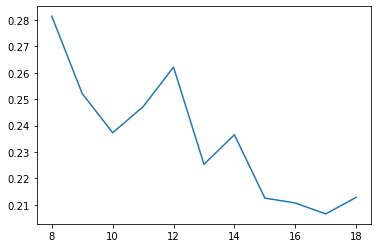

In [75]:
scaled_matrix_B=obtain_best_num_cluster(X_B)

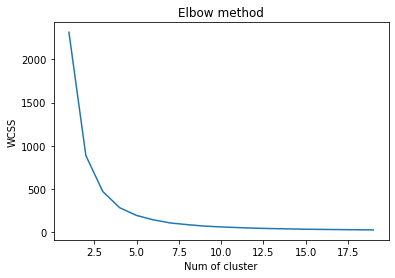

In [57]:
 plot_elbow (X_A)

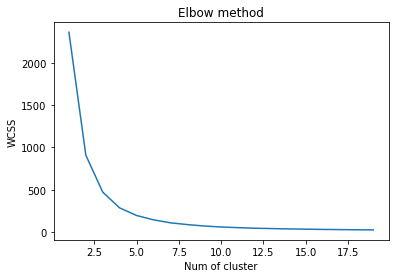

In [60]:
 plot_elbow (X_B)

In [76]:
def cluster_distribution(n_cluster, mean_vector):

    clf=KMeans(n_clusters=n_cluster, max_iter=100, init='k-means++', n_init=1)
    clf.fit(X_A)
    labels=clf.predict(X_A)

    anzahlen=pd.DataFrame(pd.Series(labels).value_counts(), columns=['num sentence']).T
    print(anzahlen)
    anzahlen.plot(kind='bar', figsize=(15,5))
    
    return labels


                 3     5    1    0    8    4    2    7    6
num sentence  1178  1151  912  900  684  570  301  286  157


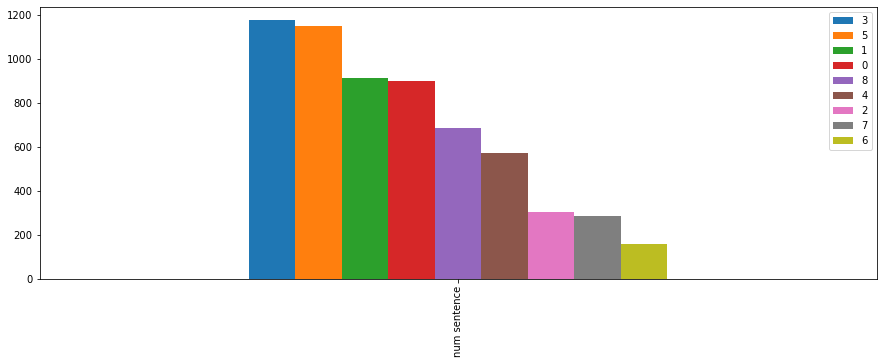

In [96]:
labels_A=cluster_distribution(9, X_A)

                 5     6    2    0    7    8    1    4    3
num sentence  1123  1112  921  849  799  556  331  292  156


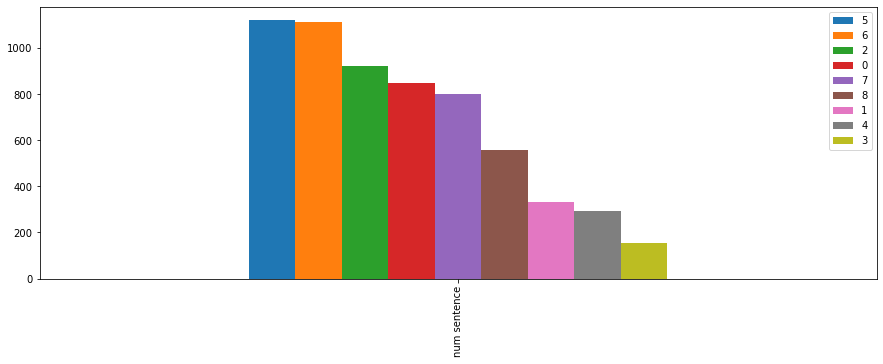

In [78]:
labels_B=cluster_distribution(9, X_B)

In [79]:
def obtain_tsne_graph (X, labels):
    X_embedded=TSNE(n_components=2).fit_transform(X)
    
    df_subset=pd.DataFrame()
    df_subset['tsne1']=X_embedded[:,0]
    df_subset['tsne2']=X_embedded[:,1]
    
    plt.figure(figsize=(16,10))
    sns.scatterplot(x='tsne1', y='tsne2', hue=labels, palette='deep', data=df_subset, legend='full', alpha=0.3)

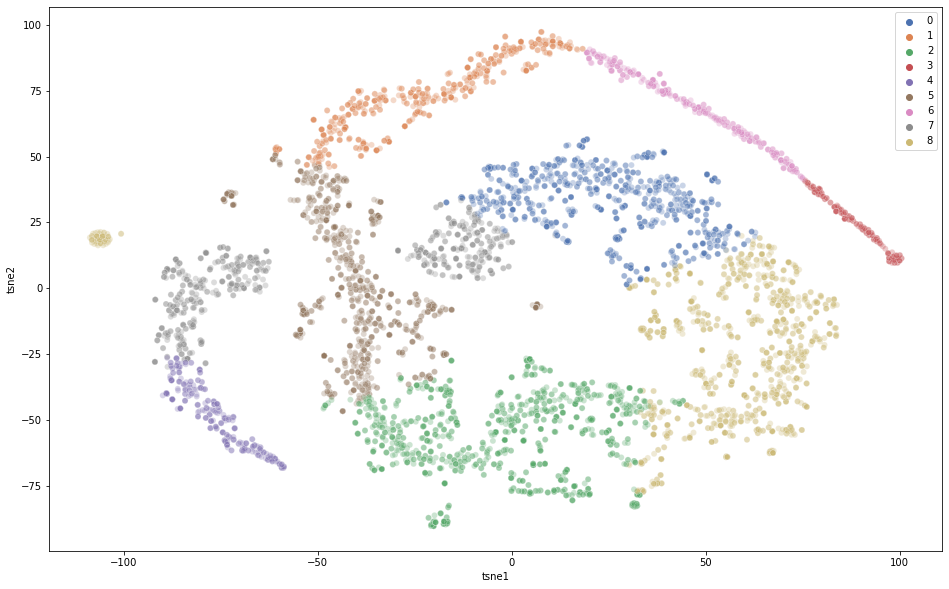

In [80]:
obtain_tsne_graph (X_A,labels_A)

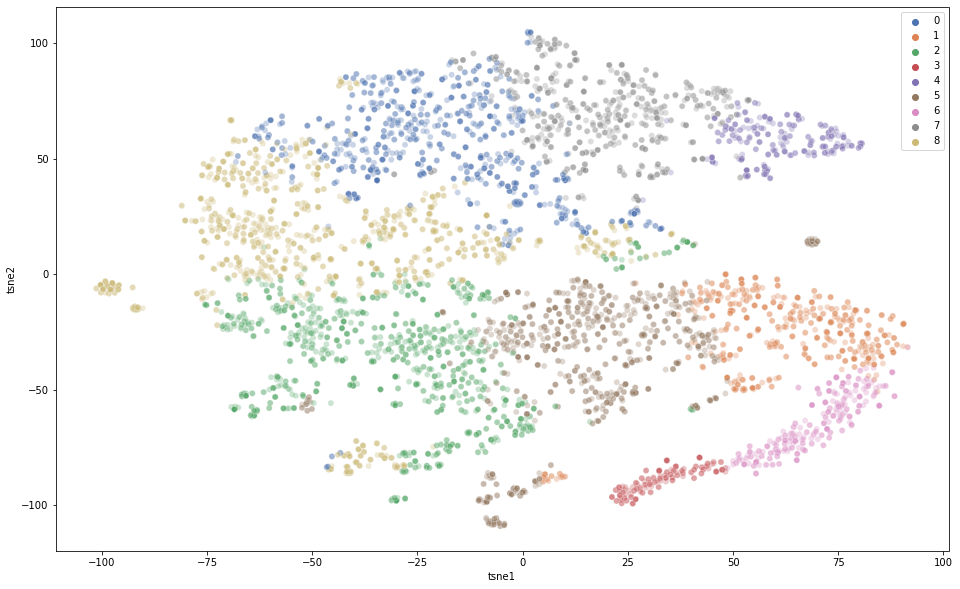

In [94]:
obtain_tsne_graph (scaled_matrix_A,labels_A)

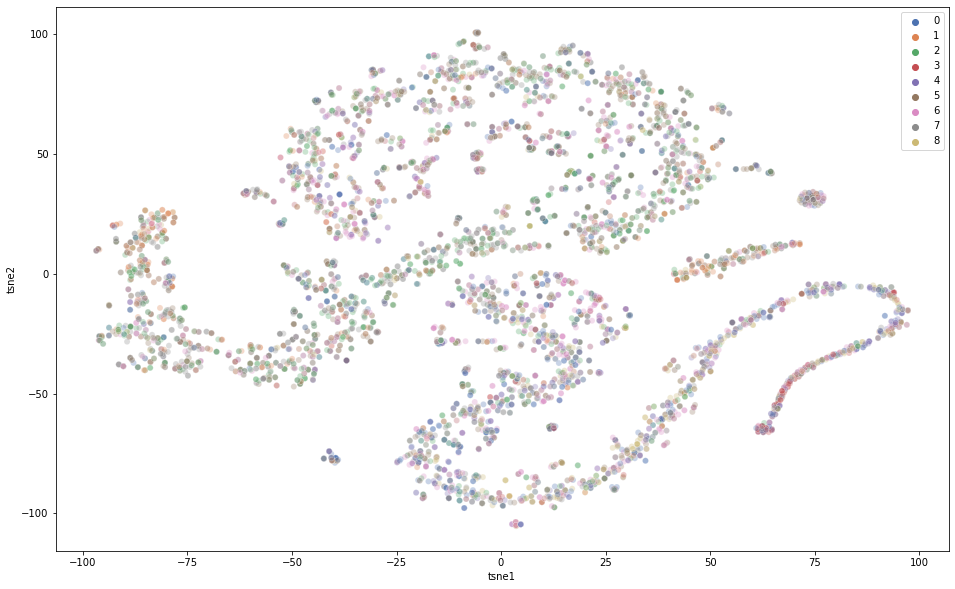

In [97]:
obtain_tsne_graph (X_B,labels_B)

In [103]:
df_final['cluster_A'] = labels_A

In [104]:
df_final['cluster_B'] = labels_B

In [105]:
df_final['same_cluster'] = np.where((df_final['cluster_A'] == df_final['cluster_B']) , 0, 1)

In [106]:
df_final

,index,sentence_A,list_words_A,sentence_B,list_words_B,mean_vector_A,mean_vector_B,dist_cos,cluster_A,cluster_B,same_cluster
0,5,There is no boy playing outdoors and there is ...,"[boy, playing, outdoors, smilin]",A group of kids is playing in a yard and an ol...,"[group, kids, playing, yard, old, standing, ba...","[-0.21429284, 0.09112359, 0.05202782, -0.24113...","[-0.25212032, 0.10952699, 0.064085044, -0.2887...",0.999870,3,5,1
1,6,A group of boys in a yard is playing and a man...,"[group, boys, yard, playing, standing, backgroun]",The young boys are playing outdoors and the ma...,"[young, boys, playing, outdoors, smiling, nearb]","[-0.27004054, 0.11861211, 0.067443065, -0.3098...","[-0.20310707, 0.09119358, 0.050980374, -0.2350...",0.999949,8,7,1
2,7,A group of children is playing in the house an...,"[group, children, playing, house, standing, ba...",The young boys are playing outdoors and the ma...,"[young, boys, playing, outdoors, smiling, nearb]","[-0.2622532, 0.11449351, 0.06541927, -0.299947...","[-0.20310707, 0.09119358, 0.050980374, -0.2350...",0.999938,8,7,1
3,9,A brown dog is attacking another animal in fro...,"[brown, attacking, another, animal, front, tal...",A brown dog is attacking another animal in fro...,"[brown, attacking, another, animal, front, pant]","[-0.21504, 0.0962875, 0.052011628, -0.24964492...","[-0.23563944, 0.10411026, 0.056666553, -0.2712...",0.999996,3,5,1
4,10,A brown dog is attacking another animal in fro...,"[brown, attacking, another, animal, front, pant]",A brown dog is helping another animal in front...,"[brown, helping, another, animal, front, pant]","[-0.23563944, 0.10411026, 0.056666553, -0.2712...","[-0.23893152, 0.10500013, 0.058312286, -0.2761...",0.999995,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...
6134,9832,A door is being opened by a man,[opene],A bald man in a band is playing guitar in the ...,"[bald, band, playing, guitar, spotligh]","[0.0011909533, -0.00047562766, 0.002919638, -0...","[-0.12299605, 0.051961344, 0.033220924, -0.137...",-0.014555,6,3,1
6135,9836,Someone is boiling okra in a pot,"[someone, boiling, okr]",The man is not playing the drums,"[playing, drum]","[-0.15734847, 0.06900994, 0.04406911, -0.18544...","[-0.14375556, 0.06628352, 0.037264865, -0.1517...",0.998408,0,0,0
6136,9837,The man is singing heartily and playing the gu...,"[singing, heartily, playing, guita]",A bicyclist is holding a bike over his head in...,"[bicyclist, holding, bike, head, group, peopl]","[-0.15180147, 0.065046996, 0.03991281, -0.1639...","[-0.24253584, 0.10082939, 0.059706673, -0.2855...",0.999040,0,0,0
6137,9838,A man in blue has a yellow ball in the mitt,"[blue, yellow, bal]",A man is jumping rope outside,"[jumping, rope, outsid]","[-0.32614735, 0.14461873, 0.08157906, -0.38382...","[-0.21396096, 0.09454978, 0.05243293, -0.24362...",0.999868,7,1,1


In [107]:
df_final.loc[df_final['same_cluster']==0]

,index,sentence_A,list_words_A,sentence_B,list_words_B,mean_vector_A,mean_vector_B,dist_cos,cluster_A,cluster_B,same_cluster
10,19,There is no man in a black jacket doing tricks...,"[black, jacket, tricks, motorbik]",A person in a black jacket is doing tricks on ...,"[person, black, jacket, tricks, motorbik]","[-0.1952259, 0.08676389, 0.048544582, -0.22308...","[-0.22479586, 0.09857904, 0.05561433, -0.25907...",0.999952,5,5,0
56,103,Four kids are doing backbends in the park,"[four, kids, backbends, par]",Four girls are doing backbends and playing out...,"[four, girls, backbends, playing, outdoor]","[-0.19392246, 0.083251216, 0.047499303, -0.222...","[-0.20159559, 0.08674034, 0.04977425, -0.22226...",0.999890,5,5,0
78,146,A group is not riding the current in a raft,"[group, riding, current, raf]",This group of people is practicing water safet...,"[group, people, practicing, water, safety, wea...","[-0.1918358, 0.07710232, 0.048745282, -0.22579...","[-0.2396438, 0.10189873, 0.061957795, -0.28316...",0.999801,5,5,0
79,148,A deer is jumping over a fence,"[deer, jumping, fenc]",A deer is jumping over the enclosure,"[deer, jumping, enclosur]","[-0.19872786, 0.08605635, 0.046582002, -0.2245...","[-0.16567802, 0.068602495, 0.03593127, -0.1871...",0.999952,5,5,0
80,150,A wild deer is jumping a fence,"[wild, deer, jumping, fenc]",A deer is jumping a fence,"[deer, jumping, fenc]","[-0.15854646, 0.06923658, 0.03760538, -0.17798...","[-0.19872786, 0.08605635, 0.046582002, -0.2245...",0.999989,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6128,9819,The woman is picking up the kangaroo,"[woman, picking, kangaro]",A man is standing on the top of a roof and pla...,"[standing, top, roof, playing, violi]","[-0.14684556, 0.065807514, 0.038317595, -0.173...","[-0.2022061, 0.088863485, 0.052664936, -0.2293...",0.999023,0,0,0
6131,9822,A homeless man is holding up a sign and is beg...,"[homeless, holding, sign, begging, mone]",The woman and the man are travelling by car,"[woman, travelling, ca]","[-0.15454805, 0.06404, 0.040551994, -0.1825847...","[-0.18033469, 0.07882827, 0.04594857, -0.22019...",0.999410,0,0,0
6135,9836,Someone is boiling okra in a pot,"[someone, boiling, okr]",The man is not playing the drums,"[playing, drum]","[-0.15734847, 0.06900994, 0.04406911, -0.18544...","[-0.14375556, 0.06628352, 0.037264865, -0.1517...",0.998408,0,0,0
6136,9837,The man is singing heartily and playing the gu...,"[singing, heartily, playing, guita]",A bicyclist is holding a bike over his head in...,"[bicyclist, holding, bike, head, group, peopl]","[-0.15180147, 0.065046996, 0.03991281, -0.1639...","[-0.24253584, 0.10082939, 0.059706673, -0.2855...",0.999040,0,0,0


Determine a metric, to see if pair of sentences being in the same cluster, have a cosine_distance superior to a define threshold.

In [108]:
df_final['dist_cos'].mean()

0.9915806469636418

In [115]:
df_final['dist_cos'].quantile(.85)

0.999995231628418

In [117]:
df_final_q_85=df_final.loc[df_final['dist_cos']>=0.999995231628418]

In [120]:
df_final_q_85.loc[df_final_q_85['same_cluster']==0]

,index,sentence_A,list_words_A,sentence_B,list_words_B,mean_vector_A,mean_vector_B,dist_cos,cluster_A,cluster_B,same_cluster
85,155,A deer is jumping a fence,"[deer, jumping, fenc]",A deer isn't jumping over the fence,"[deer, jumping, fenc]","[-0.19872786, 0.08605635, 0.046582002, -0.2245...","[-0.19872786, 0.08605635, 0.046582002, -0.2245...",1.000000,5,5,0
86,156,A deer is jumping over a fence,"[deer, jumping, fenc]",A deer is jumping a fence,"[deer, jumping, fenc]","[-0.19872786, 0.08605635, 0.046582002, -0.2245...","[-0.19872786, 0.08605635, 0.046582002, -0.2245...",1.000000,5,5,0
129,230,Three Asian kids are dancing and a serious man...,"[three, asian, kids, dancing, serious, lookin]",Three Asian kids are dancing and a man is looking,"[three, asian, kids, dancing, lookin]","[-0.18819405, 0.081120305, 0.046348438, -0.223...","[-0.22412935, 0.09610334, 0.054969627, -0.2661...",0.999997,5,5,0
627,1225,A woman is peeling a potato,"[woman, peeling, potat]",There is no woman peeling a potato,"[woman, peeling, potat]","[-0.19221948, 0.07902575, 0.05743113, -0.23241...","[-0.19221948, 0.07902575, 0.05743113, -0.23241...",1.000000,5,5,0
628,1227,A woman is slicing a tomato,"[woman, slicing, tomat]",There is no woman slicing a tomato,"[woman, slicing, tomat]","[-0.1986097, 0.07945702, 0.058500726, -0.23553...","[-0.1986097, 0.07945702, 0.058500726, -0.23553...",1.000000,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...
5436,8275,A child is playing slip and slide in the grass,"[child, playing, slip, slide, gras]",A child is not playing slip and slide in the g...,"[child, playing, slip, slide, gras]","[-0.19584647, 0.08805766, 0.04935698, -0.21623...","[-0.19584647, 0.08805766, 0.04935698, -0.21623...",1.000000,5,5,0
5443,8292,A motorcyclist on a bike is leaning into a sha...,"[motorcyclist, bike, leaning, sharp, corne]",There is no motorcyclist on a bike leaning int...,"[motorcyclist, bike, leaning, sharp, corne]","[-0.14124155, 0.061009992, 0.03505251, -0.1673...","[-0.14124155, 0.061009992, 0.03505251, -0.1673...",1.000000,0,0,0
5783,9052,There is no guy leaping into the air in a wood...,"[guy, leaping, air, wooded, are]",A guy is leaping into the air in a wooded area,"[guy, leaping, air, wooded, are]","[-0.13843587, 0.061508484, 0.037535373, -0.160...","[-0.13843587, 0.061508484, 0.037535373, -0.160...",1.000000,0,0,0
5787,9063,There is no dog running with a volleyball,"[running, volleybal]",A dog is running with a volleyball,"[running, volleybal]","[-0.15796335, 0.07691867, 0.032524887, -0.1961...","[-0.15796335, 0.07691867, 0.032524887, -0.1961...",1.000000,0,0,0
